In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
#pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
dataset = pd.read_csv("house-prices-and-images-socal/socal2.csv")

In [5]:
dataset.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [6]:
dataset.drop(columns=['image_id', 'street', 'n_citi'], inplace=True)

In [7]:
dataset.head()

,citi,bed,bath,sqft,price
0,"Salton City, CA",3,2.0,1560,201900
1,"Brawley, CA",3,2.0,713,228500
2,"Imperial, CA",3,1.0,800,273950
3,"Brawley, CA",3,1.0,1082,350000
4,"Calexico, CA",4,3.0,2547,385100


In [8]:
#Turn categorical city data into numerical data
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,bed,bath,sqft,price,"29 Palms, CA","Acton, CA","Adelanto, CA","Agoura Hills, CA","Agua Dulce, CA","Aguanga, CA",...,"Wildomar, CA","Wilmington, CA","Winchester, CA","Winnetka, CA","Wofford Heights, CA","Woodland Hills, CA","Wrightwood, CA","Yorba Linda, CA","Yucaipa, CA","Yucca Valley, CA"
0,3,2.0,1560,201900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2.0,713,228500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,800,273950,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1.0,1082,350000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3.0,2547,385100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#These columns have a std of zero, messes up normalization
dataset.drop(columns=['Corona del Mar, CA', 'Guadalupe, CA', 'Panorama City, CA', 'Shadow Hills, CA', 'Vandenberg Village, CA'], inplace=True)

In [10]:
#Split data
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

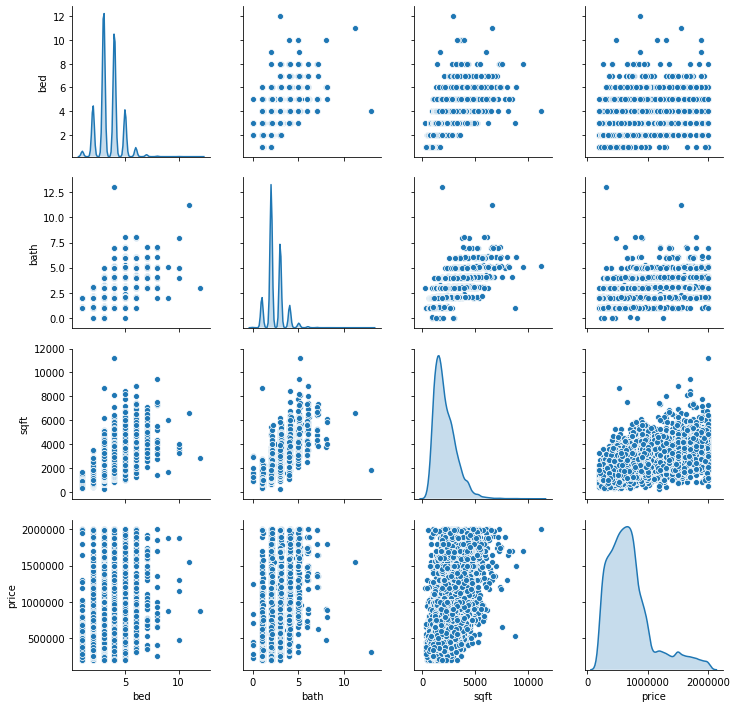

In [11]:
sns.pairplot(train_dataset[['bed', 'bath', 'sqft', 'price']], diag_kind="kde")

In [12]:
#Get stats
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
bed,12379.0,3.500364,1.032074,1.0,3.0,3.0,4.0,12.0
bath,12379.0,2.447314,0.914389,0.0,2.0,2.1,3.0,13.0
sqft,12379.0,2168.818968,1015.500884,280.0,1428.0,1945.0,2730.0,11183.0
"29 Palms, CA",12379.0,0.000727,0.026955,0.0,0.0,0.0,0.0,1.0
"Acton, CA",12379.0,0.001212,0.034790,0.0,0.0,0.0,0.0,1.0


In [13]:
#Remove target value
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [14]:
#Checking for std of 0
d = train_stats['std']
d[d == 0]

Series([], Name: std, dtype: float64)

In [15]:
#Normalize data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
#Check for NaNs in normalized data
d = normed_train_data.isna().sum()
d[d != 0]

Series([], dtype: int64)

In [17]:
#build the model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [18]:
model = build_model()

In [19]:
#Test model
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.1263449 ],
       [ 0.17153025],
       [ 1.1914096 ],
       [ 0.4835776 ],
       [ 0.35381848],
       [ 1.8516762 ],
       [ 0.46586624],
       [ 0.12549588],
       [ 0.3688057 ],
       [-0.03125069]], dtype=float32)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                26496     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 30,721
Trainable params: 30,721
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Training
"""EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])"""

'EPOCHS = 1000\n\nhistory = model.fit(\n  normed_train_data, train_labels,\n  epochs=EPOCHS, validation_split = 0.2, verbose=0,\n  callbacks=[tfdocs.modeling.EpochDots()])'

In [22]:
#View training history
"""hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()"""

"hist = pd.DataFrame(history.history)\nhist['epoch'] = history.epoch\nhist.tail()"

In [23]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [24]:
"""#Plot training MAE
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 300000])
plt.ylabel('MAE [price]')"""

'#Plot training MAE\nplotter.plot({\'Basic\': history}, metric = "mae")\nplt.ylim([0, 300000])\nplt.ylabel(\'MAE [price]\')'

In [25]:
"""#Plot training MSE
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 10**11])
plt.ylabel('MSE [price^2]')"""

'#Plot training MSE\nplotter.plot({\'Basic\': history}, metric = "mse")\nplt.ylim([0, 10**11])\nplt.ylabel(\'MSE [price^2]\')'

In [26]:
#Retrain with early stopping to prevent overfitting
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 100000
early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:636157517819.8639,  mae:703214.6875,  mse:636157689856.0000,  val_loss:616649467669.0920,  val_mae:692952.8125,  val_mse:616649392128.0000,  
....................................................................................................
Epoch: 100, loss:82010651965.0336,  mae:165294.2656,  mse:82010669056.0000,  val_loss:84075875015.3409,  val_mae:169893.8750,  val_mse:84075888640.0000,  
....................................................................................................
Epoch: 200, loss:71582872947.5270,  mae:150723.7969,  mse:71582883840.0000,  val_loss:73364322598.4620,  val_mae:154761.5938,  val_mse:73364324352.0000,  
....................................................................................................
Epoch: 300, loss:64313825926.2688,  mae:142587.3281,  mse:64313839616.0000,  val_loss:66125600096.3619,  val_mae:146784.5156,  val_mse:66125594624.0000,  
..........................................................................

Text(0, 0.5, 'MAE [price]')

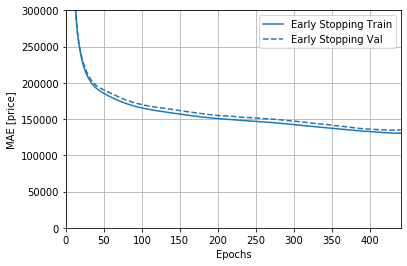

In [27]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 300000])
plt.ylabel('MAE [price]')

In [28]:
#Evaluate with test data
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3095/3095 - 0s - loss: 109848445920.5686 - mae: 156586.7656 - mse: 109848436736.0000
Testing set Mean Abs Error: 156586.77 MPG


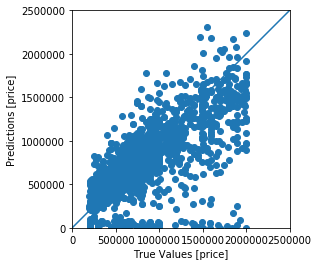

In [29]:
#Plot predictions
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 2.5e6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

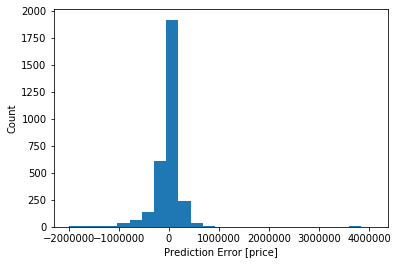

In [30]:
#Plot prediction error
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [price]")
_ = plt.ylabel("Count")

In [31]:
model.save('regression.h5')